# Загрузка и установка дополнительных библиотек

In [1]:
!nvidia-smi

Thu Nov 17 15:29:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install numpy
!pip install pandas
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install  arff2pandas
!pip install -U pandas-profiling
!pip install sklearn
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement arff2pandas (from versions: none)
ERROR: No matching distribution found for arff2pandas
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачиваем архив с датасетами

In [4]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
!unzip -qq ECG5000.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 298MB/s]
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Импортируем необходимые для работы модули и библиотеки.

In [5]:
import torch

На базе PyTorch будет происходить моделирование нейронной сети LSTM автоэнкодера для обнаружения аномалий на временном отрезке данных.

In [6]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn, optim

import torch.nn.functional as F
from scipy.io.arff import loadarff 


Все остальные библиотеки нужны для разметки данных, математических вычислений, отображение инфографики, манипуляций с данными.

In [7]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Настройка параметров отображение инфографики, генератора случайных чисел на новую последовательность, путём задавания RANDOM_SEED. Обозначаем для PyTorch вычислительный юнит графического процессора с помощью архитектуры "Cuda", если данное вычисление невозможно, то PyTorch будет производить вычисления с помощью Центрального процессора системы.

In [8]:
with open('ECG5000_TRAIN.arff') as f:
  train = loadarff(f)


with open('ECG5000_TEST.arff') as f:
  test = loadarff(f)

Загружаются данные в обучающую и тренировочную выборки.

In [9]:
#df = pd.concat([train,test],ignore_index=True)
df_train = pd.DataFrame(train[0])
df_test = pd.DataFrame(test[0])
df_train = df_train.sample(frac=1.0)
df_test = df_test.sample(frac=1.0)
df = df_train.merge(df_test, how='outer')
print(df.head())


       att1      att2      att3      att4      att5      att6      att7  \
0  0.863391 -0.519657 -1.430022 -2.179920 -2.563066 -2.672148 -2.768067   
1  1.753771  0.377447 -1.531644 -2.836151 -3.872459 -4.149665 -3.165177   
2 -0.816690 -1.305508 -1.302504 -1.658546 -1.743282 -1.855752 -2.107553   
3  1.285554 -0.193298 -1.973573 -2.882901 -3.874288 -3.971114 -2.939585   
4 -0.905406 -3.160866 -4.055624 -4.872467 -4.394382 -3.278555 -1.942058   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -2.638626 -2.239692 -1.624667  ... -2.230418 -2.697570 -3.110212 -3.416757   
1 -1.930740 -1.629826 -1.085945  ...  1.204625  1.981789  1.716358  2.243991   
2 -2.107902 -1.959048 -1.699431  ... -1.067329 -1.649166 -2.163573 -2.695111   
3 -1.959100 -1.771962 -0.842970  ...  0.098938  0.952556  1.253251  1.134577   
4 -1.331610 -1.245225 -0.284257  ...  1.695323  1.810844  2.048302  1.920703   

     att136    att137    att138    att139    att140  target  
0 -3.4

Создаётся общий датафрейм

In [10]:
CLASS_NORMAL = 1
class_name = ['Normal','PVC','R on T','SP','UB']

Создаётся кортеж классов.

In [11]:
new_columns = list(df.columns)
print(new_columns)
new_columns[-1] = 'target'
df.columns = new_columns

['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9', 'att10', 'att11', 'att12', 'att13', 'att14', 'att15', 'att16', 'att17', 'att18', 'att19', 'att20', 'att21', 'att22', 'att23', 'att24', 'att25', 'att26', 'att27', 'att28', 'att29', 'att30', 'att31', 'att32', 'att33', 'att34', 'att35', 'att36', 'att37', 'att38', 'att39', 'att40', 'att41', 'att42', 'att43', 'att44', 'att45', 'att46', 'att47', 'att48', 'att49', 'att50', 'att51', 'att52', 'att53', 'att54', 'att55', 'att56', 'att57', 'att58', 'att59', 'att60', 'att61', 'att62', 'att63', 'att64', 'att65', 'att66', 'att67', 'att68', 'att69', 'att70', 'att71', 'att72', 'att73', 'att74', 'att75', 'att76', 'att77', 'att78', 'att79', 'att80', 'att81', 'att82', 'att83', 'att84', 'att85', 'att86', 'att87', 'att88', 'att89', 'att90', 'att91', 'att92', 'att93', 'att94', 'att95', 'att96', 'att97', 'att98', 'att99', 'att100', 'att101', 'att102', 'att103', 'att104', 'att105', 'att106', 'att107', 'att108', 'att109', 'att110', 'att111

Переименновывается последняя колонка датафрейма, для лучшего ориентирования в нём (датафрейме)

In [12]:
df.target.value_counts()
df = df.sort_values(df.columns[-1])

Проверка колчиство примеров для каждого класса сердцебиения

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


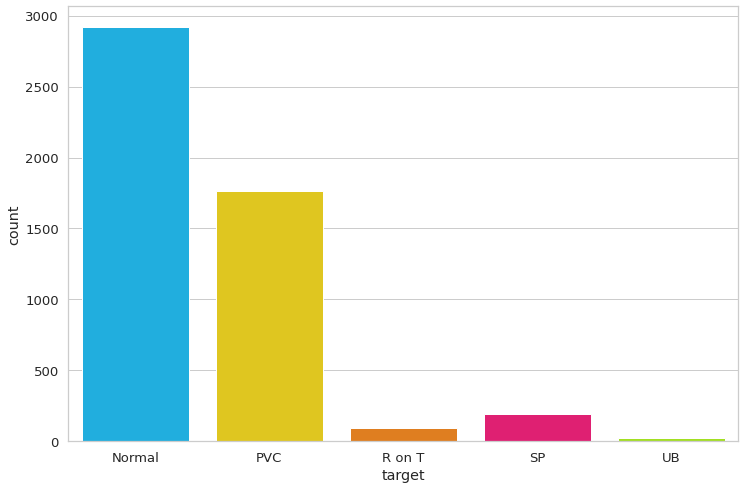

In [13]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_name);

По графикам видно, что большее количество примеров приходится на нормальное сердцебиение. На них как будет производится последующее обучение.

In [14]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

Выведем инфорграфику усредненного временного ряда для каждого класса сердцебиения

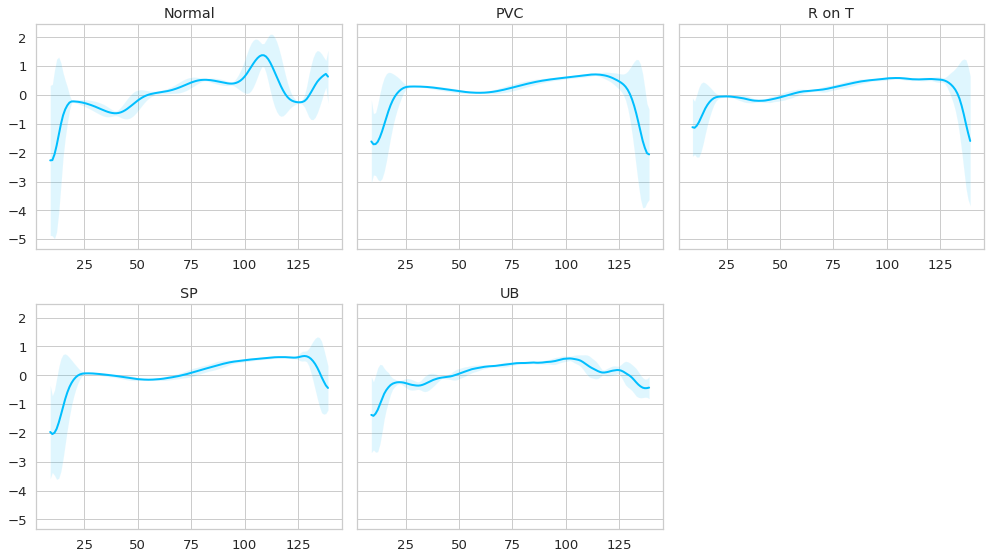

In [15]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_name[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Поведение класса "Normal" отличается от других, что даёт возможность обучения модели на загруженных данных

In [16]:
normal_df = df[df.target == df.target[1]].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

Выделение класса "Normal" в отдельный датафрейм

In [17]:
anomaly_df = df[df.target != df.target[1]].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

Остальные классы переходят в датафрейм для аномалий

In [18]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

Класс "Normal" разделяется на три датафрейма: обучение, валидация и тестирование.

In [19]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

Вводится дополнительная функция для форматирования датасетов. Это необходимо для исплоьзования датафреймов, как тензеров, при обучении  автоэнкодера.

In [20]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

Каждый временной ряд будет конвертирован в двухмерный тензор (длина последовательности Х количество признаков) 

# Автоэнкодер

Основная архитектура автоэнкодера содержит в себе два компонента. Энкодер, который сжимает входные данные, и Декодер, который после реконструеирует их. 

In [21]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

В реализации энкодера используется две LSTM слоя для сжатия входных временных рядов 

In [22]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


Декодер содержит два слоя LSTM и выходный слой, который выводит реконстрированные данные

Объединение двух модулей в одну нейронную сеть

In [23]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Создание сущности модели нейронной сети

In [24]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# Обучение

Создаётся вспомогательная функция для процесса обучения, где настраиваются такие параметры как: количество эпох, величина фунцкии потерь, валидация функции потерь.

Epoch 1: train loss 73.00071719844992 val loss 56.96312140767485
Epoch 2: train loss 54.7127652858256 val loss 59.0539016202855
Epoch 3: train loss 54.10829308205005 val loss 53.93799131478059
Epoch 4: train loss 52.20503416065245 val loss 51.81484865572672
Epoch 5: train loss 50.850318079944195 val loss 50.21094800669179
Epoch 6: train loss 45.78453964439432 val loss 39.69407166881366
Epoch 7: train loss 35.59605716496213 val loss 30.975610446604446
Epoch 8: train loss 28.66370773699821 val loss 28.41434195586846
Epoch 9: train loss 26.663492603294316 val loss 29.665825160290193
Epoch 10: train loss 25.297643425098496 val loss 28.105411929888938
Epoch 11: train loss 24.718572292535452 val loss 28.685093026926086
Epoch 12: train loss 24.307011146499285 val loss 29.061577793681174
Epoch 13: train loss 23.186827963275903 val loss 24.465763485879215
Epoch 14: train loss 22.082152657237856 val loss 21.899442620651715
Epoch 15: train loss 20.76006659938654 val loss 20.838202912652857


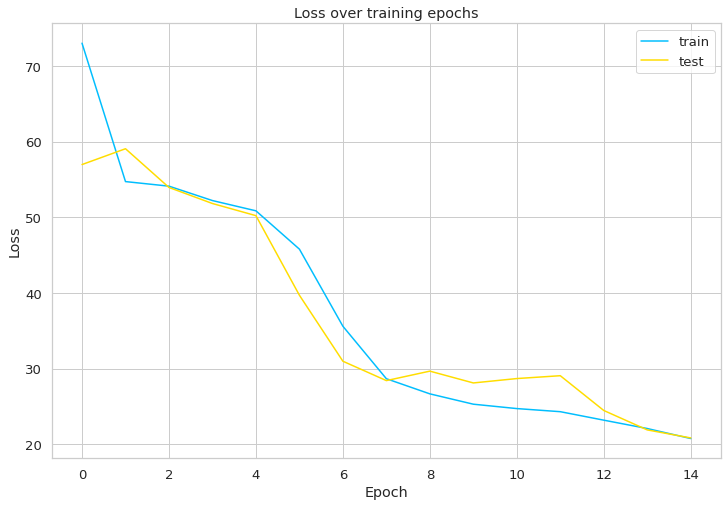

In [25]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=15
)


ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

В каждую эпоху процесс обучения передаёт модели все обучающие примеры и оценивает произовадительность на проверочном наборе. Модель при обучении распознаёт только одну последовательность за раз. Также, записываются потери наборов обучения и валидации в процессе. 

Минимизируется L1Loss, который измеряет среднюю абсолютную ошибку. Так как при среднеквадратичной ошибке реконструированные данные не дают такой картины. 

Проводим обучение модели.





Сохранение обученной модели

In [26]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Создаёются функция для предсказывания. С её помощью будет видно сколько ошибок будет на выходе после реконструирования

In [27]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in tqdm(dataset):
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Эта функция проходит через каждый пример в датасете и записывает величены предсказывания и потери. Далее на изображении можно увидеть потери.

100%|██████████| 2481/2481 [00:08<00:00, 284.32it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


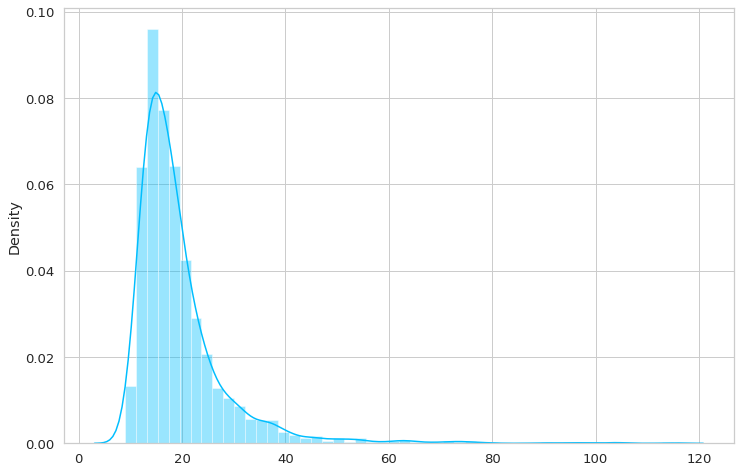

In [28]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [29]:
THRESHOLD = 26

# Оценка

Используя пороговое значение = 26, решается задача уже бинарной классификации.


Если потеря реконструкции для примера ниже порогового значения, то это классифицируется как нормальное средцебиение. Иначе классифицируется как аномалия. 


100%|██████████| 145/145 [00:00<00:00, 284.63it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


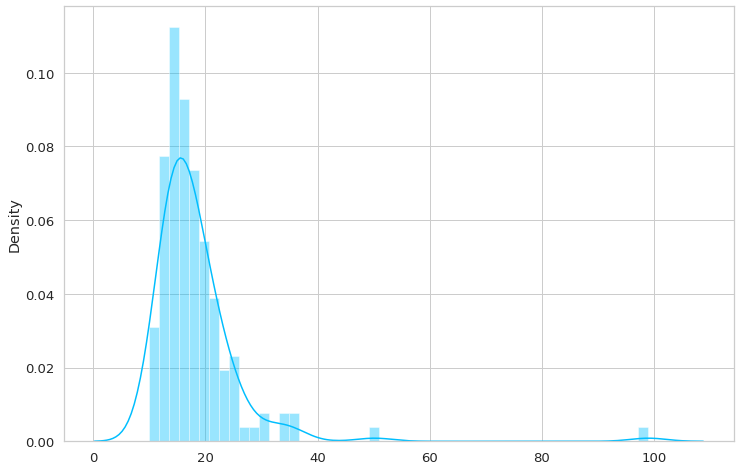

In [30]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Нормальное сердцебиение. Проверка качества работы модели по определению нормального сердцебиения. Используется класс "Normal" из тестового набора.

In [31]:
correct = sum(l <= 26 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 135/145


Повторяем предидущие действия для примеров аномалий. Ограничим из количество количетсвом нормального сердцебиения.

In [32]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Теперь проведём предсказание модели на новом подмножестве.

100%|██████████| 145/145 [00:00<00:00, 264.90it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


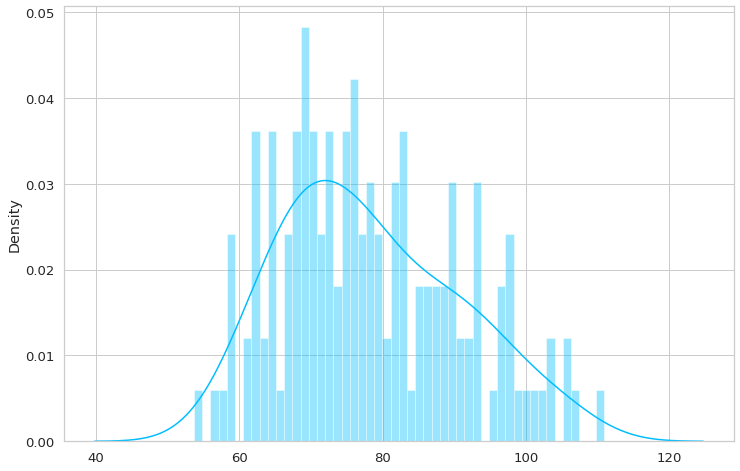

In [33]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [34]:
correct = sum(l > 26 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 145/145


Все аномальные ритмы сердце были определены верно. Настройка порогового значения сильно зависит от количества эпох обучения. В данном случае не представилось возможности настолько чётко обучить модель. Для этого требуется много вычислительных мощностей и времени. Но ложноположительные результаты, тоже хороший показатель. Так как, все аномалии зарегитрированы, то дополнительное обследование пациентов с ложноположительными результатами может выдать более глубокую аномалию. 

# Эксперименты

Наложим реальные и реконструированные значения временных рядов, чтобы увидеть насколько они близки. Данное действие проводиться не некторого количетсва нормальных и аномальных случаев.

In [35]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

100%|██████████| 1/1 [00:00<00:00, 107.22it/s]


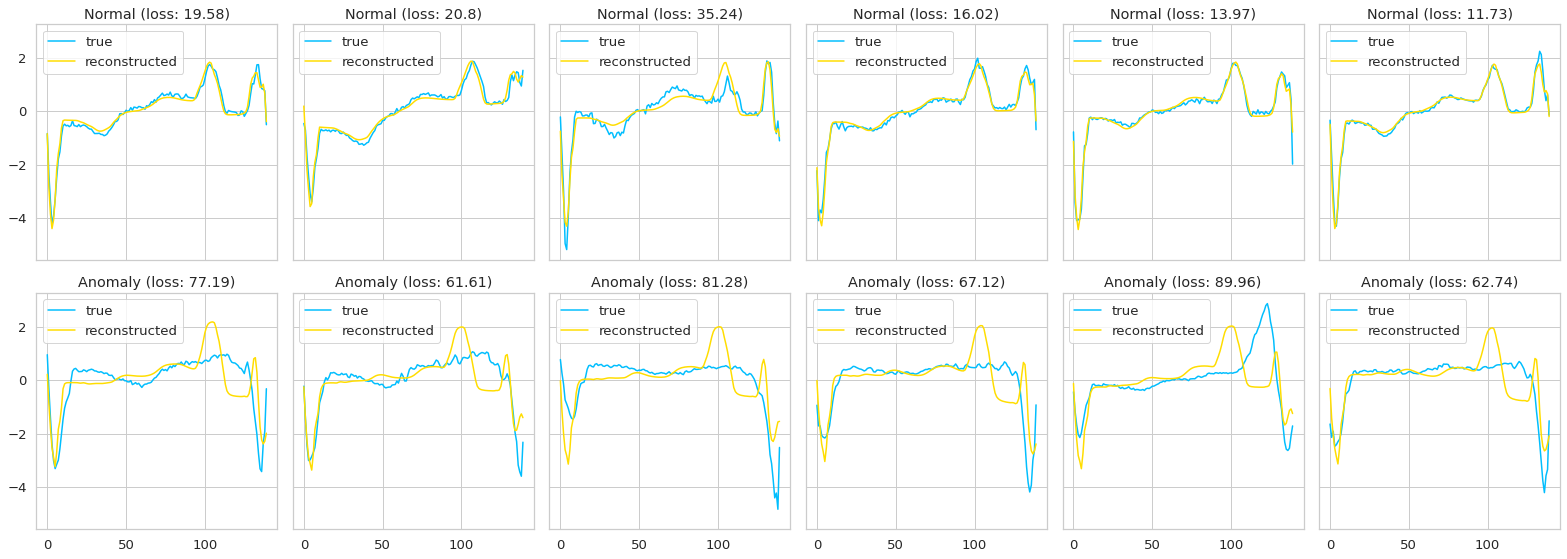

In [36]:

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();